# GRAPE for CNOT

In [1]:
# ruff: noqa

"""
Gradient Ascent Pulse Engineering (GRAPE)
"""

import jax.numpy as jnp
import sys

from feedback_grape.grape import optimize_pulse, plot_control_amplitudes
from feedback_grape.utils.gates import cnot
from feedback_grape.utils.operators import identity, sigmax, sigmay, sigmaz
from feedback_grape.utils.tensor import tensor

# Example usage
g = 0  # Small coupling strength
H_drift = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))
H_ctrl = [
    tensor(sigmax(), identity(2)),
    tensor(sigmay(), identity(2)),
    tensor(sigmaz(), identity(2)),
    tensor(identity(2), sigmax()),
    tensor(identity(2), sigmay()),
    tensor(identity(2), sigmaz()),
    tensor(sigmax(), sigmax()),
    tensor(sigmay(), sigmay()),
    tensor(sigmaz(), sigmaz()),
]

U_0 = identity(4)
# Target operator (CNOT gate)
C_target = cnot()

num_t_slots = 500
total_evo_time = 2 * jnp.pi

# Run optimization
result = optimize_pulse(
    H_drift,
    H_ctrl,
    U_0,
    C_target,
    num_t_slots,
    total_evo_time,
    max_iter=100,
    learning_rate=1e-2,
    optimizer="l-bfgs",
)
print("final_fidelity: ", result.final_fidelity)
print("U_f \n", result.final_operator)
print("Converged after: ", result.iterations)

final_fidelity:  0.9999999999989599
U_f 
 [[ 7.07106609e-01-7.07106953e-01j -5.34845594e-07+4.14435684e-07j
   4.04520234e-08+3.10559540e-07j -2.18360675e-07+3.24380039e-07j]
 [ 4.14435778e-07-5.34845649e-07j  7.07107039e-01-7.07106524e-01j
   7.58245371e-07+5.45080361e-08j -3.99727736e-07-7.12314106e-07j]
 [ 3.24379401e-07-2.18361026e-07j -7.12314256e-07-3.99727846e-07j
  -9.34418133e-08+7.11093871e-08j  7.07106660e-01-7.07106902e-01j]
 [ 3.10559687e-07+4.04524360e-08j  5.45074288e-08+7.58245305e-07j
   7.07106816e-01-7.07106746e-01j  7.11098659e-08-9.34416897e-08j]]
Converged after:  19


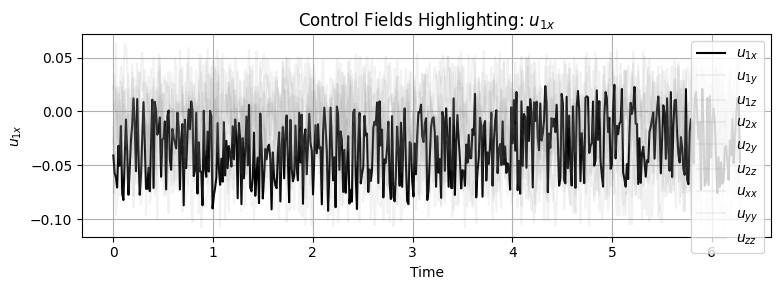

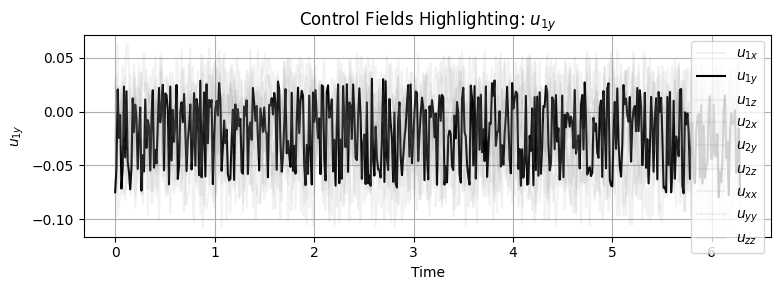

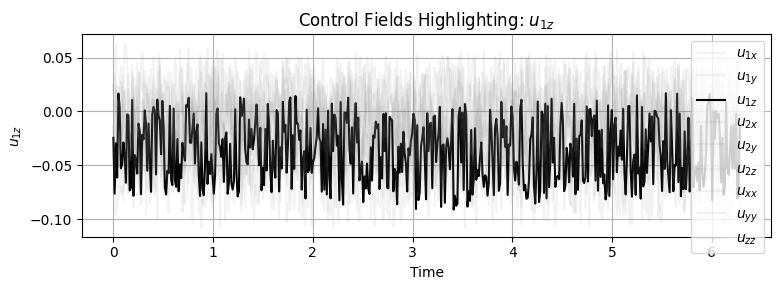

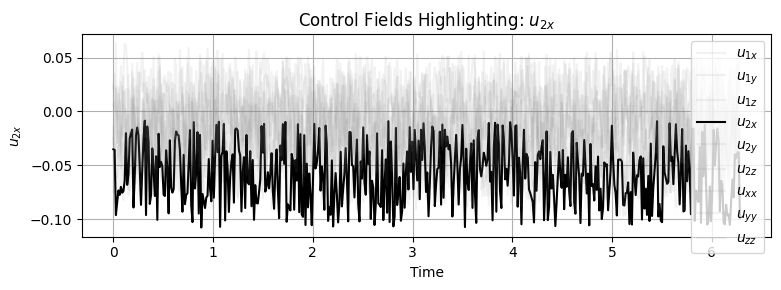

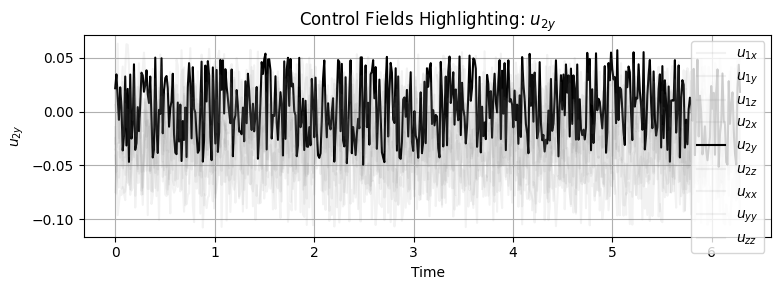

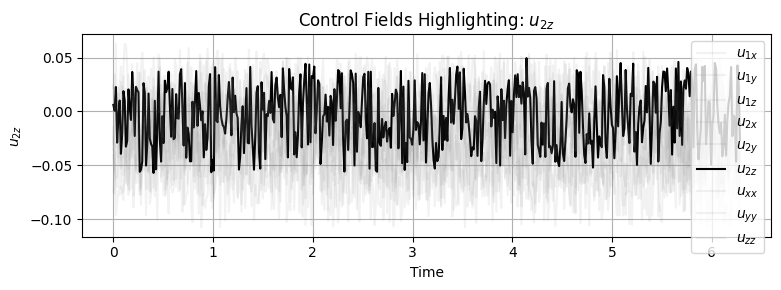

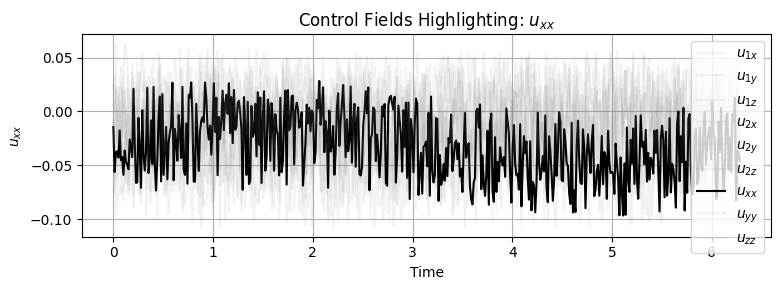

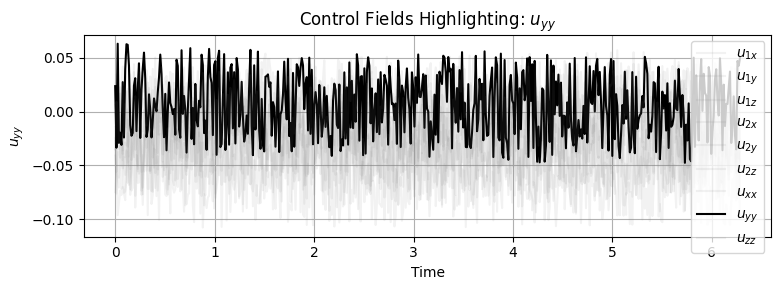

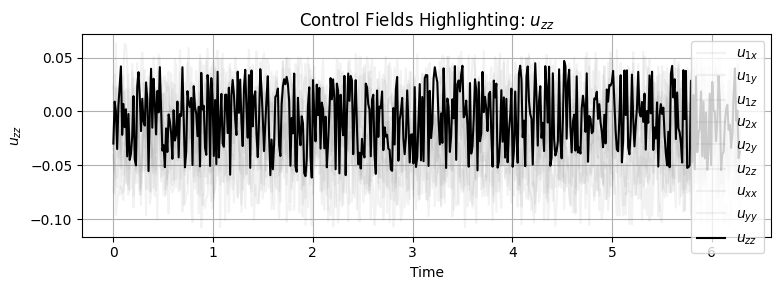

In [2]:
times = jnp.linspace(0, 2 * jnp.pi, 500)
H_labels = [
    r'$u_{1x}$',
    r'$u_{1y}$',
    r'$u_{1z}$',
    r'$u_{2x}$',
    r'$u_{2y}$',
    r'$u_{2z}$',
    r'$u_{xx}$',
    r'$u_{yy}$',
    r'$u_{zz}$',
]
plot_control_amplitudes(
    times, result.control_amplitudes / (2 * jnp.pi), H_labels
)

In [3]:
U_target = cnot()
U_f = result.final_operator

In [4]:
def overlap(U_target, U_f):
    """
    Calculate the overlap between the target unitary U_target and the final unitary U_f.

    Parameters:
    U_target (qutip.Qobj): Target unitary operator.
    U_f (qutip.Qobj): Final unitary operator.

    Returns:
    float: Real part of the overlap value.
    float: Fidelity (absolute square of the overlap).
    """
    # dividing over U_target.shape[0] is for normalization
    overlap_value = (
        jnp.trace(jnp.matmul(U_target.conj().T, U_f)) / U_target.shape[0]
    )
    fidelity = abs(overlap_value) ** 2
    return overlap_value.real, fidelity


# Example usage
overlap_real, fidelity = overlap(U_target, U_f)
print(f"Overlap (real part): {overlap_real}")
print(f"Fidelity: {fidelity}")

Overlap (real part): 0.7071067811861799
Fidelity: 0.9999999999989599
